## Dependencies

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

In [2]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

# NYPD Civilian Complaints
This project contains data on 12,000 civilian complaints filed against New York City police officers. 

### Getting the Data
The data and its corresponding data dictionary is downloadable [here](https://www.propublica.org/datastore/dataset/civilian-complaints-against-new-york-city-police-officers).

#### Import data

In [3]:
allegations = pd.read_csv('allegations.csv')
df = allegations.copy()
df.head()

,unique_mos_id,first_name,last_name,command_now,shield_no,complaint_id,month_received,year_received,month_closed,year_closed,...,mos_age_incident,complainant_ethnicity,complainant_gender,complainant_age_incident,fado_type,allegation,precinct,contact_reason,outcome_description,board_disposition
0,10004,Jonathan,Ruiz,078 PCT,8409,42835,7,2019,5,2020,...,32,Black,Female,38.0,Abuse of Authority,Failure to provide RTKA card,78.0,Report-domestic dispute,No arrest made or summons issued,Substantiated (Command Lvl Instructions)
1,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,24,Black,Male,26.0,Discourtesy,Action,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges)
2,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,24,Black,Male,26.0,Offensive Language,Race,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges)
3,10007,John,Sears,078 PCT,5952,26146,7,2012,9,2013,...,25,Black,Male,45.0,Abuse of Authority,Question,67.0,PD suspected C/V of violation/crime - street,No arrest made or summons issued,Substantiated (Charges)
4,10009,Noemi,Sierra,078 PCT,24058,40253,8,2018,2,2019,...,39,NaN,NaN,16.0,Force,Physical force,67.0,Report-dispute,Arrest - other violation/crime,Substantiated (Command Discipline A)


### Introduction

The prediction problem I am attempting is a classification problem. I aim to build a model to predict whether the `mos_ethnicity` of an NYPD officer is **White** or **Not White**. 

I intend to make this prediction based on data relevant to the allegation case before an outcome is decided. I will then calculate several metrics from the model:

* `Accuracy`: The proportion of predictions that were correctly identified
* `Precision`: The proportion of **White** identifications that were correctly identified
* `Recall`: The proportion of **Not White** identifications that were correctly identified
* `F1 score`: The harmonic mean of precision and recall

Although all metrics above are important for evaluating a well-functioning model, I will select `F1 score` for evaluating my model. A higher `F1 score` translates to a model which correctly identifies White **and** Not White police officers since it is the harmonic mean of `Precision` and `Recall`. This provides a more granular and balanced understanding of the predictions than `Accuracy`, or any one of `Precision` or `Recall`.

### Data Pre-Processing

Select training and target columns. Inspect data for missingness, and unique values.

In [4]:
#Select training and target columns
columns = ['mos_ethnicity', 'mos_gender', 'mos_age_incident',
           'complainant_ethnicity', 'complainant_gender', 'complainant_age_incident', 
           'rank_incident', 'precinct', 'fado_type', 'allegation',  
           'contact_reason', 'outcome_description']

df = df[columns]
#Check for missingness
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33358 entries, 0 to 33357
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   mos_ethnicity             33358 non-null  object 
 1   mos_gender                33358 non-null  object 
 2   mos_age_incident          33358 non-null  int64  
 3   complainant_ethnicity     28894 non-null  object 
 4   complainant_gender        29163 non-null  object 
 5   complainant_age_incident  28546 non-null  float64
 6   rank_incident             33358 non-null  object 
 7   precinct                  33334 non-null  float64
 8   fado_type                 33358 non-null  object 
 9   allegation                33357 non-null  object 
 10  contact_reason            33159 non-null  object 
 11  outcome_description       33302 non-null  object 
dtypes: float64(2), int64(1), object(9)
memory usage: 3.1+ MB


We cannot impute meaningful data in any of these columns without introducing bias

In [5]:
df['mos_ethnicity'].unique()

array(['Hispanic', 'White', 'Black', 'Asian', 'American Indian'],
      dtype=object)

Binarize `mos_ethnicity` for prediction purposes

In [6]:
def binarize_ethnicity(ethnicity):
    if ethnicity == 'White':
        return 1
    else:
        return 0

In [7]:
df['mos_ethnicity'] = df['mos_ethnicity'].apply(binarize_ethnicity)
df = df.dropna(subset=['mos_ethnicity'])

Inspect Proportion of White (1) vs Other (1) Ethnicity

Text(0.5, 1.0, 'NYPD Proportion of White (1) vs Other (1) Ethnicity')

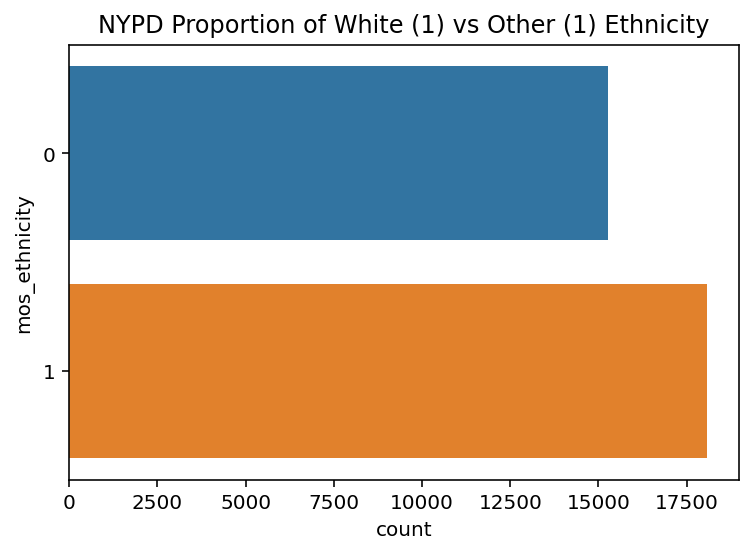

In [8]:
sns.countplot(y='mos_ethnicity', data=df).set_title('NYPD Proportion of White (1) vs Other (1) Ethnicity')

Roughly 54% of NYPD officers are white.

In [9]:
# Proportion of Males vs. Females
df['mos_ethnicity'].value_counts(normalize=True)

1    0.541819
0    0.458181
Name: mos_ethnicity, dtype: float64

### Baseline Model
I will only use data relevant to the allegation case before an outcome is decided in the allegations table. This is in order to justify the information known only at the "time of prediction" and training the model using only those features.

- quantitative data: `complainaint_age_incident`, `mos_age_incident`, `precinct`
- categorical data (all nominal): `mos_gender`, `complainant_gender'`, `complainant_ethnicity`, `fado_type`, `allegation`, `rank_incident`, `contact_reason`, `outcome_description`

All data listed is available at the time of prediction as we aim to predict the ethnicity of the officer before the case is closed. In total, I have 11 features. None are ordinal due to their nature and because we are using a `DecisionTreeClassifier` model.

I imputed missing data from the selected columns with `-1` if quantitative or `NULL` if categorical. I did, however, binarize the output column of `mos_ethnicity`, defining 1 corresponding to White and 0 corresponding to Not White ethniciites to simplify predictions. The categorical columns were then one-hot encoded and fed into the `DecisionTreeClassifier` model with default parameters. 

The average base model performance on unseen data is as follows:
- `Accuracy`: 0.7864508393285371
- `Precision`: 0.8027657673252436
- `Recall`: 0.8012972064300221
- `F1 score`: 0.8020130982611654

This is not a bad baseline model, looking at the F1 score. It performs substantially better than a random choice model which guesses ethnicity using ethnicity proportions in the dataset as probabilities. There is, however, still a lot of scope for improvement. This baseline model can not be used reliably for predictions.

#### Create baseline DecisionTreeClassifier model:
- Impute -1 for quantitative columns
- Impute 'NULL' for categorical columns
- One hot encode categorical columns

In [10]:
# Select quantitative columns
num_feat = ['complainant_age_incident', 
            'mos_age_incident',
            'precinct']
num_transformer = Pipeline(steps=[
    # Impute -1
    ('imp', SimpleImputer(strategy='constant', fill_value=-1))
])

# Select categorical columns
cat_feat = ['mos_gender',
            'complainant_gender', 
            'complainant_ethnicity',
            'fado_type', 
            'allegation', 
            'rank_incident', 
            'contact_reason', 
            'outcome_description']

cat_transformer = Pipeline(steps=[
    # Impute NULL 
    ('imp', SimpleImputer(strategy='constant', fill_value='NULL')),
    # One hot encode categorical columns. Ignore unknown values
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

preproc = ColumnTransformer(transformers=[
    ('num', num_transformer, num_feat), 
    ('cat', cat_transformer, cat_feat)
])

- We iteratively split data and train the model to to average out variation in metrics due to random splits in `train_test_split`
- Calculate average of metrics from `mos_ethnicity` predictions of base model. 

In [11]:
scores = []
precisions = []
recalls = []
f1_scores = []

# To avoid random error in splitting data
for i in range(10):
    #Split data into training and testing sets using default sklearn split
    X_train, X_test, y_train, y_test = train_test_split(
        df.drop('mos_ethnicity', axis=1), 
        df['mos_ethnicity']
    )
    pl_base = Pipeline(steps=[
        ('preprocessor', preproc), 
        ('classifier', DecisionTreeClassifier())
    ])
    pl_base.fit(X_train, y_train)
    preds = pl_base.predict(X_test)
    
    #Extract positive and negative identifications and errors
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, preds).ravel()
    #Accuracy score
    scores.append(pl_base.score(X_test, y_test))
    # Precision
    precision = tp/(tp+fp)
    precisions.append(precision)
    # Recall
    recall = tp/(tp+fn)
    recalls.append(recall)
    #F1 Score
    f1_score = (2 * precision * recall)/(precision + recall)
    f1_scores.append(f1_score)

In [12]:
base_accuracy = np.mean(scores)
base_precision = np.mean(precisions)
base_recall = np.mean(recalls)
base_f1 = np.mean(f1_scores)

base_metrics = {'Accuracy': base_accuracy, 
                'Precision': base_precision,
                'Recall': base_recall, 
                'F1 Score': base_f1}
base_metrics

{'Accuracy': 0.7864868105515587,
 'Precision': 0.803803046663163,
 'Recall': 0.8023055397540192,
 'F1 Score': 0.8030234834920804}

Find most important features from base model. They appear to be: 
- `complainant_ethnicity`
- `mos_age_incident`
- `mos_gender`

Note that `precinct` is completely unimportant

In [13]:
d = dict(zip(X_train.columns, pl_base.steps[1][1].feature_importances_))
sorted(d.items(), key=lambda item: item[1], reverse=True)

[('complainant_ethnicity', 0.18352557902959857),
 ('mos_gender', 0.14895016311520418),
 ('mos_age_incident', 0.14575137541253472),
 ('complainant_age_incident', 0.012998949164602243),
 ('rank_incident', 0.010369840490624407),
 ('fado_type', 0.009418709211204093),
 ('allegation', 0.006192837770173487),
 ('contact_reason', 0.00023418478478285163),
 ('complainant_gender', 0.0),
 ('precinct', 0.0),
 ('outcome_description', 0.0)]

### Final Model

To improve upon the baseline model, I made the following changes to the feature set:
1. I engineered a brand new feature called `time_elapsed` which calculates the amount of time in days that the allegation case was closed using the `month_received`, `year_received`, `month_closed`, and `year_closed` columns in the allegations table. This is a good feature as there may be a correlation between officer ethnicity and the amount of time taken to close allegation cases due to systemic biases in the NYPD. Since it is known that racial biases exist in police departments, this feature may help predict the ethnicity of the police officer.
2. I changed `precinct` from a quantitative feature to a categorical feature by converting it to a string. This is because precincts are nominal zones that officers are allotted to. The precinct number does not carry weight or order. One-hot encoding this feature will provide more useful data for the model as precincts contain different proportions of ethnicities, with some precincts being predominantly white.
3. I scaled the numerical columns using `RobustScaler` to reduce the impact of outliers and imputed data on the model predictions.

I proceeded to use the `DecisionTreeClassifier` with the above 12 features because it is an appropriate classifier, has scope for finetuning parameters to improve generalization, and performed better than I anticipated in the base model. I selected the best parameters using `GridSearchCV` with `cv` set to 5. `GridSearchCV` checks all combinations of the given parameters and specifies the best ones for the final model. These were:
- `max_depth`: None
- `min_samples_split`: 1
- `min_samples_leaf`: 3

These parameters are very close to the default parameters. Average final model performance using the above parameters on unseen data is as follows:
- `Accuracy`: 0.8116546762589929
- `Precision`: 0.8289738837350773
- `Recall`: 0.8210347338388646
- `F1 score`: 0.8249712669992325

There appears to be modest improvement across all metrics. Most importantly, the `F1 score` improved, which indicates that the model performed better in correctly identifying both White and Not White police officers. Examining the important features from the `DecisionTreeClassifier`, we see that `time_elapsed` plays a role in the classification and `precinct` is no longer completely unimportant. However, this model still does not appear to be completely reliable.

Create new feature titled `time_elapsed` which determines the number of days that the allegation file remained open

In [14]:
def time_elapsed(year1, year2, month1, month2):
    #Convert year and month to datetime objects
    start = pd.to_datetime('{}-{}'.format(year1, month1))
    end = pd.to_datetime('{}-{}'.format(year2, month2))
    
    #Extract days from relativedelta object
    return (end - start).days

In [15]:
df['time_elapsed'] = allegations.apply(lambda x: time_elapsed(
    x['year_received'], x['year_closed'], x['month_received'], x['month_closed']
), axis=1)

Convert `precinct` into a categorical feature

In [16]:
df['precinct'] = df['precinct'].astype(str)

Create feature engineered DecisionTreeClassifier model:
- Impute -1 into quantitative columns
- Standardize quantitative columns, including new `time_elapsed` feature
- Impute 'NULL' for categorical columns
- One hot encode categorical columns

In [17]:
# Select quantitative columns
num_feat = ['complainant_age_incident', 
            'mos_age_incident',
            'time_elapsed']
num_transformer = Pipeline(steps=[
    # Impute -1
    ('imp', SimpleImputer(strategy='constant', fill_value=-1)),
    # Robust scale numerical columns to reduce impact of outliers
    
    ('scale', RobustScaler())
])

# Select categorical columns
cat_feat = ['precinct',
            'mos_gender',
            'complainant_gender', 
            'complainant_ethnicity',
            'fado_type', 
            'allegation', 
            'rank_incident', 
            'contact_reason', 
            'outcome_description']

cat_transformer = Pipeline(steps=[
    # Impute NULL 
    ('imp', SimpleImputer(strategy='constant', fill_value='NULL')),
    # One hot encode categorical columns. Ignore unknown values
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

preproc = ColumnTransformer(transformers=[
    ('num', num_transformer, num_feat), 
    ('cat', cat_transformer, cat_feat)
])

Perform a grid search with 5 `cross_validation` folds to find the best `DecssionTreeClassifier` parameters

In [18]:
params = {
    'classifier__max_depth': [5,10,15,20,None],
    'classifier__min_samples_split': [1,3,5,7,10,None],
    'classifier__min_samples_leaf': [1,3,5,7,10,None]
}

X_train, X_test, y_train, y_test = train_test_split(
    df.drop('mos_ethnicity', axis=1), 
    df['mos_ethnicity']
)

pl_final = Pipeline(steps=[
    ('preprocessor', preproc), 
    ('classifier', DecisionTreeClassifier())
])

grid = GridSearchCV(pl_final, cv=5, param_grid=params, n_jobs=-1)
grid.fit(X_train, y_train)
grid.best_params_

{'classifier__max_depth': None,
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 3}

- We iteratively split data and train the final model to to average out variation in metrics due to random splits in `train_test_split`
- Calculate average of metrics from `mos_ethnicity` predictions of final model using above parameters. 

In [19]:
scores = []
precisions = []
recalls = []
f1_scores = []

for i in range(10):
    #Split data into training and testing sets using default sklearn split
    X_train, X_test, y_train, y_test = train_test_split(
        df.drop('mos_ethnicity', axis=1), 
        df['mos_ethnicity']
    )
    pl_final = Pipeline(steps=[
        ('preprocessor', preproc), 
        ('classifier', DecisionTreeClassifier(max_depth=None, min_samples_split=3, min_samples_leaf=1))
    ])
    pl_final.fit(X_train, y_train)
    #Accuracy score
    scores.append(pl_final.score(X_test, y_test))
    preds = pl_final.predict(X_test)
    
    #Extract positive and negative identifications and errors
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, preds).ravel()
    # Precision
    precision = tp/(tp+fp)
    precisions.append(precision)
    # Recall
    recall = tp/(tp+fn)
    recalls.append(recall)
    #F1 Score
    f1_score = (2 * precision * recall)/(precision + recall)
    f1_scores.append(f1_score)

In [20]:
final_accuracy = np.mean(scores)
final_precision = np.mean(precisions)
final_recall = np.mean(recalls)
final_f1 = np.mean(f1_scores)

final_metrics = {'Accuracy': final_accuracy, 
                'Precision': final_precision,
                'Recall': final_recall, 
                'F1 Score': final_f1}
final_metrics

{'Accuracy': 0.812410071942446,
 'Precision': 0.8324519943941395,
 'Recall': 0.8191545514554509,
 'F1 Score': 0.8257261121317276}

There appears to be a modest improvement across all metrics

Find most important features from base model. They are still: 
- `complainant_ethnicity`
- `mos_age_incident`
- `mos_gender`

However, we note that `time_elapsed` plays a role in the classification and `precinct` is no longer completely unimportant

In [21]:
d = dict(zip(X_train.columns, pl_final.steps[1][1].feature_importances_))
dict(sorted(d.items(), key=lambda item: item[1], reverse=True))

{'complainant_ethnicity': 0.12188387831543862,
 'mos_age_incident': 0.10629643780765105,
 'mos_gender': 0.10081014010004301,
 'allegation': 0.006469419960400583,
 'outcome_description': 0.005514013926467992,
 'complainant_age_incident': 0.0029765580936638256,
 'time_elapsed': 0.0027411407901999398,
 'rank_incident': 0.002684489399723798,
 'contact_reason': 0.0022053716668646904,
 'precinct': 0.0015129430326987613,
 'complainant_gender': 0.0002973099975640261,
 'fado_type': 0.0}

### Fairness Evaluation
    
We know that males are overrepresented in the population of NYPD police officers. To understand whether the final model predicts ethnicities fairly for both genders, we must perform an inference analysis on the prediction results for the entire dataset.

We run a permutation test to evaluate final model for fairness by gender using `F1 score`. We use this as our parity measure as it is the harmonic mean of `Precision` and `Recall`, both of which are important to determine if White and Not White ethnicities were correctly identified. This has been explained above.

We run our permutation test with the following hypotheses and set significance level:
- `Null Hypothesis`: my model is fair; the `F1 score` for the two subsets are roughly the same
- `Alternative Hypothesis`: my model is unfair; the `F1 score` for the male subset is higher than the female subset
- `Significance Level`: 0.05, default value

**Result**: With a p-value of 0, we reject the `Null Hypothesis` in favour of the `Alternative Hypothesis`. That is, the final model is unfair and is biased towards males.

We know that males are overrepresented in the population of NYPD police officers.

Text(0.5, 1.0, 'Counts of M vs. F in NYPD')

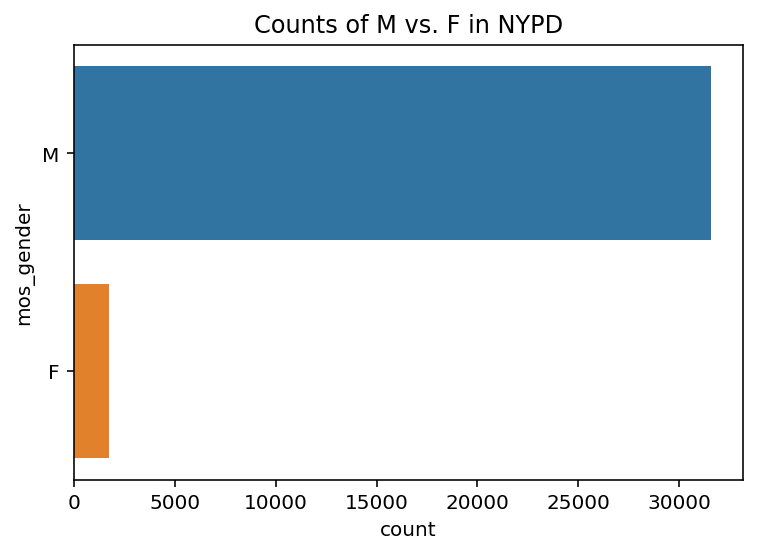

In [22]:
sns.countplot(y='mos_gender', data=df).set_title('Counts of M vs. F in NYPD')

To understand whether the final model predicts ethnicities fairly for both genders, we must perform an inference analysis on the prediction results for the entire dataset.

In [23]:
preds = pl_final.predict(df.drop('mos_ethnicity', axis=1))
df['prediction'] = preds
subset = df[['mos_gender', 'mos_ethnicity', 'prediction']]

We will run a permutation test to evaluate final model for fairness by gender using `F1 score`. We use this as our parity measure across gender as it is the harmonic mean of `Precision` and `Recall`, both of which are important metrics determining if White and Not White ethnicities were correctly identified.

- `Null Hypothesis`: my model is fair; the `F1 score` for the two subsets are roughly the same
- `Alternative Hypothesis`: my model is unfair; the `F1 score` for the male subset is higher than the female subset
- `Significance Level`: 0.05, default value

In [24]:
obs = (
    subset
    .groupby('mos_gender')
    .apply(lambda x: metrics.f1_score(x.mos_ethnicity, x.prediction))
    .diff()
    .iloc[-1]
)
# Observed difference in F1 Score
obs

0.04158790981429872

In [25]:
diffs = []
for _ in range(100):
    diff = (
        #randomly shuffle gender labels and calculate F1 scores for new groups
        subset
        .assign(mos_gender=subset.mos_gender.sample(frac=1.0, replace=False).reset_index(drop=True))
        .groupby('mos_gender')
        .apply(lambda x: metrics.f1_score(x.mos_ethnicity, x.prediction))
        .diff()
        .iloc[-1]
    )
    
    diffs.append(diff)

p-value: 0.0


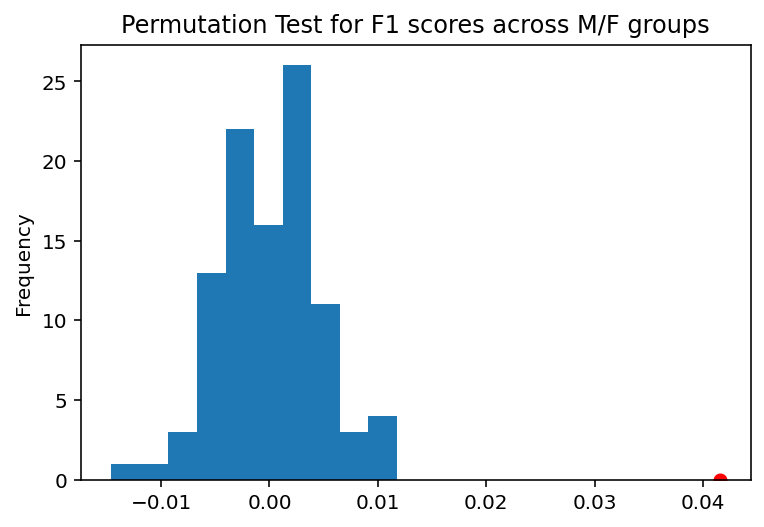

In [26]:
print('p-value:', pd.Series(diffs >= obs).mean())
pd.Series(diffs).plot(kind='hist', title='Permutation Test for F1 scores across M/F groups')
plt.scatter(obs, 0, c='r');

**Result**: With a p-value of 0, we reject the `Null Hypothesis` in favour of the `Alternative Hypothesis`. That is, the final model is unfair and is biased towards males.

This is to be expected given the bias towards males in the training data